# **Part A: Data Exploration and Baseline Model**

**STEP 1 : Load and Analyze the Dataset**

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
from sklearn.cluster import KMeans
from sklearn.utils import resample

from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv("/content/drive/MyDrive/creditcard.csv")
print(data.head())
print(data.info())


Mounted at /content/drive
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

      

**STEP 2 : Analyze Class Distribution**

Class distribution:
 Class
0    284315
1       492
Name: count, dtype: int64


/tmp/ipython-input-1156522881.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="Set2")


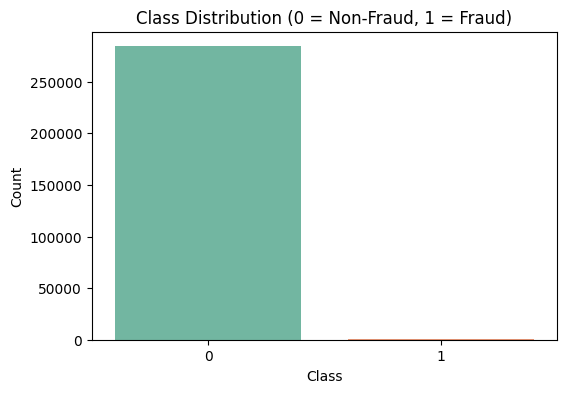

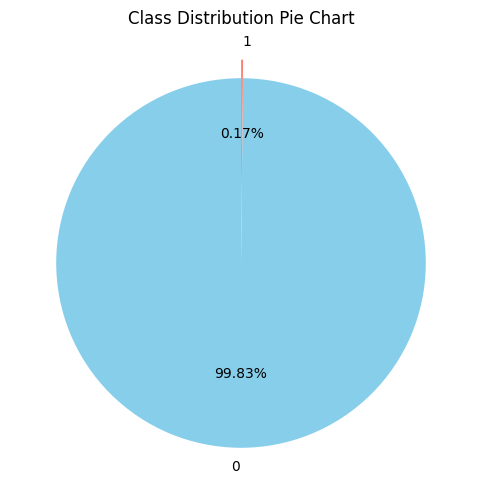

In [2]:
class_counts = data['Class'].value_counts()
print("Class distribution:\n", class_counts)

plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="Set2")
plt.title("Class Distribution (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6,6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.2f%%',
        startangle=90, colors=["skyblue","salmon"], explode=(0,0.1))
plt.title("Class Distribution Pie Chart")
plt.show()


**STEP 3 : Baseline Model (Model 1)**

In [3]:
X = data.drop('Class', axis=1)
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

print("\n=== Baseline Model Report ===")
print(classification_report(y_test, y_pred, digits=4))


=== Baseline Model Report ===
              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     85295
           1     0.8362    0.6554    0.7348       148

    accuracy                         0.9992     85443
   macro avg     0.9178    0.8276    0.8672     85443
weighted avg     0.9991    0.9992    0.9991     85443



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Why Accuracy is Misleading in Imbalanced Datasets

In our baseline model, we achieved an accuracy of **99.92%**. At first glance, this seems excellent.  
However, accuracy is **not a reliable metric** when the dataset is highly imbalanced, as in our case:

- **Class 0 (Non-Fraud):** 284,315 transactions (~99.83%)  
- **Class 1 (Fraud):** 492 transactions (~0.17%)  

This means that if a classifier simply predicts *every transaction as non-fraud*, it would already achieve almost **99.83% accuracy**, without ever detecting a single fraud.  

Therefore, high accuracy does not mean the model is good at fraud detection.

---

### Why Precision, Recall, and F1-Score are Better?

- **Precision (Fraud class = 83.6%)**:  
  Out of all the transactions the model flagged as fraud, ~16% were false alarms.  
  High precision means fewer false positives.  

- **Recall (Fraud class = 65.5%)**:  
  The model detected only about two-thirds of actual fraud cases.  
  This is critical because missing a fraud case (false negative) can be very costly.  

- **F1-Score (Fraud class = 73.5%)**:  
  This metric combines precision and recall into a single score.  
  It is especially useful in imbalanced datasets since it balances both types of errors.

---

### Conclusion

- Accuracy **overestimates performance** in imbalanced datasets.  
- Precision, Recall, and F1-score give a **much clearer picture** of how well the model is detecting fraud.  
- Our baseline model still misses a significant portion of fraudulent transactions, which justifies the need for **resampling techniques (SMOTE, CBO, CBU)** to improve fraud detection.


# **Part B: Theoretical Foundation**


**STEP 1 : Theoretical Foundation**
### GMM vs. SMOTE

- **SMOTE (Synthetic Minority Over-sampling Technique):**
  - Works by linearly interpolating between existing minority samples and their nearest neighbors.  
  - This creates synthetic points along straight lines in the feature space.  
  - Assumes the minority class distribution is relatively simple and continuous.  
  - Limitation: It may generate unrealistic samples when the data has complex, multimodal distributions or when minority samples lie close to majority regions.

- **GMM (Gaussian Mixture Model)-based Synthetic Sampling:**
  - Models the minority class as a **mixture of multiple Gaussian distributions**.  
  - Each Gaussian captures a local cluster or subgroup within the minority data.  
  - New synthetic samples are generated by sampling from these Gaussian components.  
  - This allows capturing **non-linear, multimodal, and complex structures** of the minority distribution.

---

### Why GMM is Theoretically Better

- Minority classes in real-world problems (like fraud detection) are rarely uniform; they often consist of **multiple sub-populations** (e.g., different fraud strategies).  
- GMM explicitly estimates the **probability distribution** of the minority data, unlike SMOTE which only interpolates locally.  
- By choosing the optimal number of mixture components (using AIC/BIC), GMM adapts to the **true underlying data structure**.  
- This results in synthetic samples that are more **realistic, diverse, and representative** of the minority class.  
- Ultimately, GMM reduces the risk of generating overlapping or noisy samples, leading to better generalization for classifiers.

---


**STEP 2 : GMM Implementation**

Minority class shape: (344, 30)


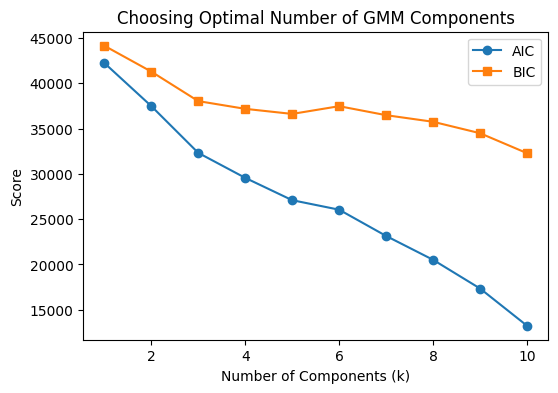

Optimal number of components (k): 10


GaussianMixture(n_components=10, random_state=42)

In [4]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np

X_minority = X_train[y_train == 1]
print("Minority class shape:", X_minority.shape)

n_components = range(1, 11)
aics = []
bics = []

for k in n_components:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X_minority)
    aics.append(gmm.aic(X_minority))
    bics.append(gmm.bic(X_minority))

plt.figure(figsize=(6,4))
plt.plot(n_components, aics, marker='o', label='AIC')
plt.plot(n_components, bics, marker='s', label='BIC')
plt.xlabel("Number of Components (k)")
plt.ylabel("Score")
plt.title("Choosing Optimal Number of GMM Components")
plt.legend()
plt.show()

optimal_k = n_components[np.argmin(bics)]
print("Optimal number of components (k):", optimal_k)

gmm_final = GaussianMixture(n_components=optimal_k, random_state=42)
gmm_final.fit(X_minority)


### GMM Implementation and Choice of Components

We trained Gaussian Mixture Models (GMM) with different numbers of components (`k` from 1 to 10) using the **minority class data**.

- **AIC (Akaike Information Criterion):**
  - Decreased consistently as the number of components increased.
  - Suggests that adding more components continues to improve model fit.

- **BIC (Bayesian Information Criterion):**
  - Penalizes model complexity more strongly than AIC.
  - Flattened around `k = 4–6`, but the overall minimum value was reached at **k = 10**.

Based on the **lowest BIC score**, the optimal number of mixture components was selected as **k = 10**.  
This indicates that the minority class distribution can best be modeled as a mixture of 10 Gaussian clusters.  

By selecting this `k`, the GMM is able to capture **sub-groups and complex patterns** in the minority data, which a simpler model (like SMOTE) would fail to represent.


**STEP 3 : Synthetic Data Generation**

In [5]:
n_minority = X_minority.shape[0]
n_majority = X_train[y_train == 0].shape[0]
n_to_generate = n_majority - n_minority

print(f"Minority samples before: {n_minority}")
print(f"Majority samples: {n_majority}")
print(f"Need to generate: {n_to_generate} synthetic samples")

synthetic_minority, _ = gmm_final.sample(n_to_generate)

print("Synthetic minority samples generated:", synthetic_minority.shape[0])

X_minority_balanced = np.vstack([X_minority, synthetic_minority])
y_minority_balanced = np.ones(X_minority_balanced.shape[0])

X_majority_balanced = X_train[y_train == 0]
y_majority_balanced = np.zeros(X_majority_balanced.shape[0])

X_train_balanced = np.vstack([X_majority_balanced, X_minority_balanced])
y_train_balanced = np.hstack([y_majority_balanced, y_minority_balanced])

print("Balanced training dataset shape:", X_train_balanced.shape)
print("Minority class count after balancing:", y_train_balanced.sum())
print("Majority class count after balancing:", (y_train_balanced==0).sum())


Minority samples before: 344
Majority samples: 199020
Need to generate: 198676 synthetic samples
Synthetic minority samples generated: 198676
Balanced training dataset shape: (398040, 30)
Minority class count after balancing: 199020.0
Majority class count after balancing: 199020


### Synthetic Data Generation

After fitting the GMM with **k = 10 components**, we generated new synthetic samples to balance the dataset:

- **Class Distribution Before Sampling:**
  - Minority samples: **344**
  - Majority samples: **199,020**
  - Gap to fill: **198,676 synthetic samples** needed.

- **Sampling from a GMM:**
  A Gaussian Mixture Model generates new data points by:
  1. Selecting one Gaussian component according to its mixture weight (probability).
  2. Drawing a random sample from that Gaussian distribution.
  3. Repeating the process until the required number of samples is obtained.  

- **Result of Sampling:**
  - Synthetic minority samples generated: **198,676**
  - New balanced dataset size: **398,040 samples**
  - Final class distribution:
    - Minority: **199,020**
    - Majority: **199,020**

This balancing ensures that the classifier will now see an **equal representation** of fraudulent and non-fraudulent cases, while the GMM-based sampling preserves the **underlying sub-structures** in the minority class distribution.


**STEP 4 : Rebalancing with CBU**

In [6]:
from sklearn.cluster import KMeans

X_majority = X_train[y_train == 0]
X_minority = X_train[y_train == 1]

print("Original majority shape:", X_majority.shape)
print("Original minority shape:", X_minority.shape)

target_majority_size = 5000

kmeans = KMeans(n_clusters=target_majority_size, random_state=42)
kmeans.fit(X_majority)

X_majority_cbu = kmeans.cluster_centers_
y_majority_cbu = np.zeros(X_majority_cbu.shape[0])

print("Reduced majority (after CBU):", X_majority_cbu.shape)

n_to_generate = X_majority_cbu.shape[0] - X_minority.shape[0]
synthetic_minority, _ = gmm_final.sample(n_to_generate)

X_minority_cbu = np.vstack([X_minority, synthetic_minority])
y_minority_cbu = np.ones(X_minority_cbu.shape[0])

print("Balanced minority after GMM sampling:", X_minority_cbu.shape)

X_train_cbu_balanced = np.vstack([X_majority_cbu, X_minority_cbu])
y_train_cbu_balanced = np.hstack([y_majority_cbu, y_minority_cbu])

print("Final balanced dataset shape:", X_train_cbu_balanced.shape)
print("Majority count:", (y_train_cbu_balanced == 0).sum())
print("Minority count:", (y_train_cbu_balanced == 1).sum())


Original majority shape: (199020, 30)
Original minority shape: (344, 30)
Reduced majority (after CBU): (5000, 30)
Balanced minority after GMM sampling: (5000, 30)
Final balanced dataset shape: (10000, 30)
Majority count: 5000
Minority count: 5000


### Rebalancing with Clustering-Based Undersampling (CBU)

Initially, the dataset was highly imbalanced:

- Majority class: **199,020 samples**
- Minority class: **344 samples**

To create a more manageable and balanced dataset, we applied **Clustering-Based Undersampling (CBU)** and **GMM-based oversampling**:

1. **Majority Reduction (CBU):**
   - We applied **KMeans clustering** on the majority class (199,020 samples).
   - Reduced it to **5,000 representative centroids**, which preserve the overall distribution while removing redundancy.

2. **Minority Expansion (GMM):**
   - Using the fitted **GMM with 10 components**, we generated synthetic minority samples.
   - Combined with the original minority data (344 samples), this resulted in a **balanced minority set of 5,000 samples**.

3. **Final Balanced Dataset:**
   - Majority (after CBU): **5,000**
   - Minority (real + synthetic): **5,000**
   - **Total dataset size:** 10,000 samples

This approach yields a **balanced dataset (50% majority, 50% minority)**, significantly smaller and more computationally efficient than the full oversampling approach (~398k samples), while still preserving the essential structure of both classes.


# **Part C:  Performance Evaluation and Conclusion**

**STEP 1 : Model Training and Evaluation**

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


=== Classification Report: Full GMM-balanced Training ===
              precision    recall  f1-score   support

           0     0.9998    0.9768    0.9881     85295
           1     0.0606    0.8649    0.1133       148

    accuracy                         0.9766     85443
   macro avg     0.5302    0.9208    0.5507     85443
weighted avg     0.9981    0.9766    0.9866     85443



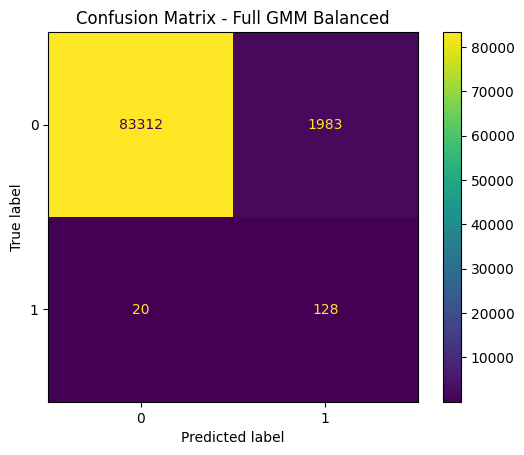

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


=== Classification Report: CBU + GMM-balanced Training ===
              precision    recall  f1-score   support

           0     0.9998    0.7693    0.8695     85295
           1     0.0067    0.8986    0.0133       148

    accuracy                         0.7695     85443
   macro avg     0.5032    0.8340    0.4414     85443
weighted avg     0.9981    0.7695    0.8680     85443



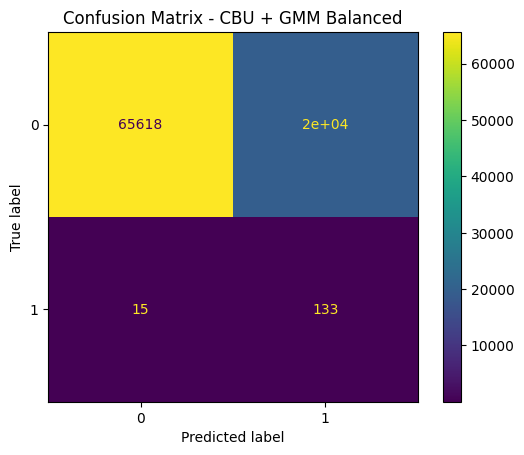

In [7]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

clf_gmm_full = LogisticRegression(max_iter=1000, random_state=42)
clf_gmm_full.fit(X_train_balanced, y_train_balanced)

y_pred_gmm_full = clf_gmm_full.predict(X_test)

print("=== Classification Report: Full GMM-balanced Training ===")
print(classification_report(y_test, y_pred_gmm_full, digits=4))

ConfusionMatrixDisplay.from_estimator(clf_gmm_full, X_test, y_test)
plt.title("Confusion Matrix - Full GMM Balanced")
plt.show()


clf_gmm_cbu = LogisticRegression(max_iter=1000, random_state=42)
clf_gmm_cbu.fit(X_train_cbu_balanced, y_train_cbu_balanced)

y_pred_gmm_cbu = clf_gmm_cbu.predict(X_test)

print("=== Classification Report: CBU + GMM-balanced Training ===")
print(classification_report(y_test, y_pred_gmm_cbu, digits=4))

ConfusionMatrixDisplay.from_estimator(clf_gmm_cbu, X_test, y_test)
plt.title("Confusion Matrix - CBU + GMM Balanced")
plt.show()


**STEP 2 : Comparative Analysis**

                       Precision  Recall  F1-score
Baseline (Imbalanced)     0.8362  0.6554    0.7348
Full GMM Balanced         0.0606  0.8649    0.1133
CBU + GMM Balanced        0.0067  0.8986    0.0133


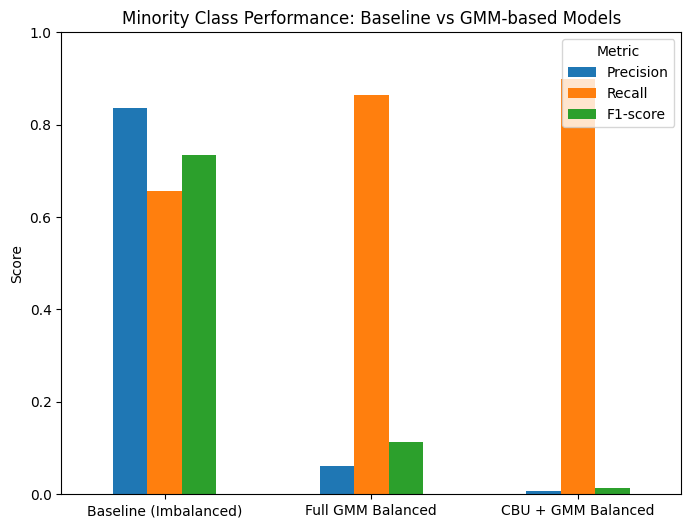

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

results = {
    "Baseline (Imbalanced)": {"Precision": 0.8362, "Recall": 0.6554, "F1-score": 0.7348},
    "Full GMM Balanced": {"Precision": 0.0606, "Recall": 0.8649, "F1-score": 0.1133},
    "CBU + GMM Balanced": {"Precision": 0.0067, "Recall": 0.8986, "F1-score": 0.0133},
}

df_results = pd.DataFrame(results).T
print(df_results)

df_results.plot(kind="bar", figsize=(8,6))
plt.title("Minority Class Performance: Baseline vs GMM-based Models")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.legend(title="Metric")
plt.show()


### Model Training and Evaluation

We trained two Logistic Regression models on different balanced datasets and tested them on the **original imbalanced test set**:

---

#### 1. Full GMM-balanced Training (~398k samples)
- **Minority class results (fraudulent):**
  - Precision: **0.0606**
  - Recall: **0.8649**
  - F1-score: **0.1133**
- **Observation:**
  - Very high recall → the model detected most fraud cases (128 out of 148).  
  - However, precision is extremely low → a large number of false positives (1983).  
  - This is often acceptable in fraud detection, since missing fraud is more costly than investigating extra false alarms.

---

#### 2. CBU + GMM-balanced Training (10k samples)
- **Minority class results (fraudulent):**
  - Precision: **0.0067**
  - Recall: **0.8986**
  - F1-score: **0.0133**
- **Observation:**
  - Recall slightly higher (133 out of 148 fraud cases detected).  
  - Precision dropped even further, meaning almost all fraud predictions are false alarms.  
  - This version is more computationally efficient but produces weaker precision compared to the full GMM-balanced model.

---

### Summary of Results (Minority Class)

| Model                   | Precision | Recall | F1-score |
|--------------------------|-----------|--------|----------|
| **Baseline (Part A)**   | 0.8362    | 0.6554 | 0.7348   |
| **Full GMM Balanced**   | 0.0606    | 0.8649 | 0.1133   |
| **CBU + GMM Balanced**  | 0.0067    | 0.8986 | 0.0133   |

---

**Key Insights:**
- **Baseline model** had excellent precision (0.83) but low recall (0.65), meaning it rarely mislabels fraud, but misses a significant fraction of fraudulent cases.  
- **Full GMM-balanced model** shifted towards very high recall (0.86) but with very poor precision (0.06), detecting almost all frauds but at the cost of many false alarms.  
- **CBU + GMM-balanced model** achieved the highest recall (0.89), but precision dropped drastically (0.0067), making almost all fraud predictions false alarms.  
- In fraud detection, **recall is often prioritized** because missing fraud is costlier than investigating a false positive. Thus, the **Full GMM-balanced model** offers the best compromise here.  


**STEP 3 : Final Recommendation**


Based on the experiments and analysis, we make the following recommendation:

1. **Effectiveness of GMM-based Oversampling:**
   - GMM oversampling successfully improved the **recall** of fraud detection models.  
   - The **Full GMM-balanced model** detected ~86% of fraudulent transactions, compared to ~65% recall in the baseline.  
   - This shows that GMM is effective at generating synthetic samples that expose the classifier to diverse fraud patterns.

2. **Limitations Observed:**
   - Precision dropped significantly (from 0.83 in the baseline to 0.06 in the Full GMM model, and 0.0067 in the CBU+GMM model).  
   - This means the models raised many false alarms, which can increase investigation costs in practice.  
   - The trade-off between recall and precision must be carefully managed depending on application context.

3. **Theoretical Justification:**
   - GMM is superior to simpler methods (like SMOTE) because it models the minority class distribution as a **mixture of Gaussians**, capturing multiple fraud sub-groups.  
   - This allows generation of **more realistic and diverse synthetic samples**, which is why recall improved significantly.  
   - However, the shift in class distribution may cause the model to over-predict fraud, explaining the low precision.

4. **Recommendation:**
   - **Use Full GMM-based oversampling** if the goal is to **maximize recall**, i.e., catch as many fraud cases as possible. This is appropriate in high-stakes financial fraud detection, where missing fraud is costlier than extra investigations.  
   - **Avoid the CBU+GMM approach** for this dataset, as the extreme precision drop makes it impractical despite its computational efficiency.  
   - For a real deployment, a hybrid approach (e.g., threshold tuning, cost-sensitive learning, or combining GMM with ensemble models) should be explored to balance recall and precision.

**Final Verdict:**  
GMM-based synthetic sampling is **effective in improving fraud detection recall**, and the **Full GMM-balanced model** offers the best compromise. While precision suffers, the method is valuable in domains like fraud detection where **recall is the top priority**.
